<H1>Challenge: Make Your Own Regression Model</H1><br><br>
This project uses the New York State crime statistics data for 2013, taken from <a href='https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls'>the FBI UCR repository</a>.<br><br>

In this data set, "Property Crime" is defined as the sum of reported burglary, larceny-theft, and motor vehicle theft. The assignment is to build a linear regression model to predict property crime, so I'll build features out of the remaining criminal data, those that aggregate into the "violent crime" category.<br><br>
An important detail is that "Robbery" is a part of the "Violent crime" aggregate, not "Property crime." For that reason, I've taken the liberty of using the robbery data to help predict property crimes, despite the fact that robbery is sometimes considered a property crime.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from scipy.stats import shapiro
%matplotlib inline
sns.set_context(font_scale=2)

In [4]:
df = pd.read_excel('clean_crime_data.xlsx')

Before engineering most features, I transform them to per capita crime rates.


In [5]:
df['PC_per_capita'], df['Burg_per_capita'] = df['Property crime']/df.Population, df['Burglary']/df.Population
df['LT_per_capita'], df['MVT_per_capita'] = df['Larceny-theft']/df.Population, df['Motor vehicle theft']/df.Population
#These are the components that add up to the "Property crime" column in the raw data.
#I ended up directy predicting the aggregate value.

<H2>Preparing the Outcome/Target Variable</H2>

Following some handy advice from the <a href'https://statswithcats.wordpress.com/2010/11/21/fifty-ways-to-fix-your-data/'> stats with cats blog</a>, I apply a cube root transform to the target variable (Property crime per capita) to get it looking like a normal distribution.<br><br>

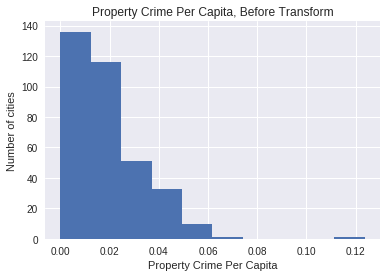

In [6]:
plt.hist(df['PC_per_capita']);
plt.title('Property Crime Per Capita, Before Transform');
plt.ylabel('Number of cities');
plt.xlabel('Property Crime Per Capita');
plt.show();

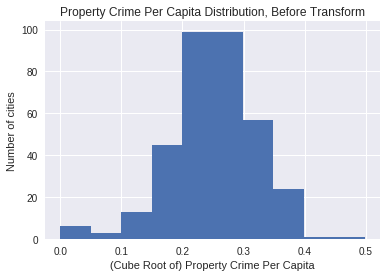

In [7]:
df['cbrt_PCpc'] = np.cbrt(df['PC_per_capita'])
plt.hist(df['cbrt_PCpc']);
plt.title('Property Crime Per Capita Distribution, Before Transform');
plt.ylabel('Number of cities');
plt.xlabel('(Cube Root of) Property Crime Per Capita');
plt.show();

That looks kind of normal! Not perfect, but it's much better than before.<br><br>

<H2>Preparing the Features</H2><br>

Now I'll build my input features. I experimented with many, but these proved to be the most powerful; there are only two 

In [8]:
df['VCpc'] = df['Violent crime']/df.Population #Aggregated property crime per capita
df['4thrt_VCpc'] = np.power(df['VCpc'], (1/4)) #Take the fourth root to get nice linear correlation to target var

#Binary feature, tags if zero violent crime in city
df['no_VC'] = np.where((df['Violent crime'] == 0), 1, 0)

#Binary feature, tags if any murder reported in city
df['has_Murd'] = np.where((df['Murder and nonnegligent manslaughter'] > 0), 1, 0)

#Binary feature, tags if New York City. Obviously a unique data point.
df['is_NYC'] = np.where((df.City == 'New York'), 1, 0)

The four above features do most of the "work" in our predictions, with a strong correlation between violent crime and property crimes. I came up with these binary features because they capture some information about the population of towns as well as the "seriousness" of crimes. The truth is that I tried a lot of these types of features, and these two just worked the best.<br><br>
Population itself, even with significant tinkering, doesn't contribute much predictive value to my model.<br><br>
The last feature does a lot, suprisingly. The raw data set has very incomplete data about arson. I found a strong linear correlation between arson and burglary for those cities who reported their arson cases:

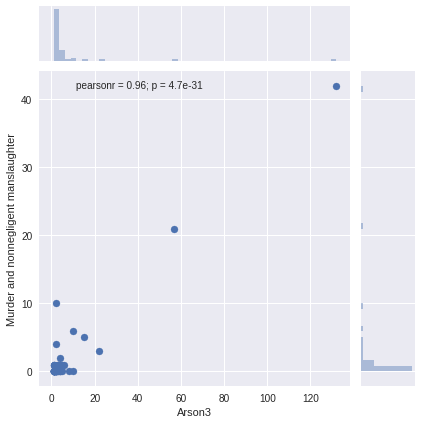

In [9]:
df['known_arson'] = np.where((df['Arson3'].notnull()), df['Arson3'], 0)
df['has_arson'] = np.where((df['Arson3'] > 0), 1, 0)
ars = df[df['has_arson'] == 1]
sns.jointplot(y=ars['Murder and nonnegligent manslaughter'], x=ars['Arson3']);

So I take advantage of that to build a quick linear regression model to populate the arson column with predicted values.

In [10]:
ars_regr = linear_model.LinearRegression()
murds = ars['Murder and nonnegligent manslaughter'].values.reshape(-1, 1)
arsn = ars.known_arson.values.reshape(-1, 1)
ars_regr.fit(murds, arsn) #fit data
ars_regr.score(murds, arsn)
df['pred_arson'] = ars_regr.predict(df['Murder and nonnegligent manslaughter'].values.reshape(-1, 1)) #predict
df['pred_arson'] = np.where((df['pred_arson'] < 0), 0, 1) #When regression gives negative values, set to zero
df['est_arson'] = np.where((df['has_arson'] == 1), df['Arson3'], df['pred_arson']) 
#use real numbers where available.

df['est_arson_per_capita'] = df['est_arson']/df.Population #per capita
df['4thrt_ars_pc'] = np.power((df['est_arson_per_capita']), (1/4)) #And take a root transform to make things tidy

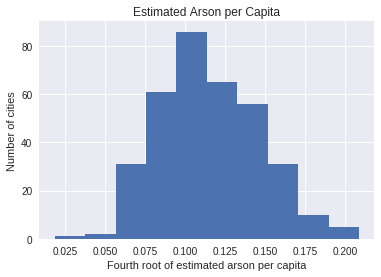

In [11]:
plt.hist(df['4thrt_ars_pc']); #Kinda normal-looking distribution
plt.title('Estimated Arson per Capita');
plt.xlabel('Fourth root of estimated arson per capita');
plt.ylabel('Number of cities');
plt.show();

<H2>Building the Model</H2>

Now I'm ready to go:

In [12]:
regr = linear_model.LinearRegression() #Instantiate the model
train = df[['4thrt_VCpc', 'is_NYC', 'no_VC', 'has_Murd', '4thrt_ars_pc']] #Our training variables
target = df[['cbrt_PCpc']] #And our outcome variable
regr.fit(train, target)

print('\nR-squared:')
print(regr.score(train, target)) #Score is pretty low due to noise.

df['raw_prediction'] = regr.predict(train) #Run model on training data
df['pred_PCpc'] = np.power(df['raw_prediction'], 3) #Transform the raw predictions to property crime per capita
df['pred_PC'] = df['pred_PCpc'] * df.Population #Multiply by population to get nominal prediction


R-squared:
0.425739800772


<H2>Evaluating Model Performance</H2><br>
Though the raw R-sqaured score for our data isn't very high, the model does well in many senses. Importantly, it yeilds accurate predictions without exhibiting any obvious signs of overfitting.<br>

<H3>Multivariate Normality</H3><br>
Because of all the work I did getting our training data to look normal, the residual distribution of the raw predictions comes out looking fairly normal; the distribution does get problematic at the tails.

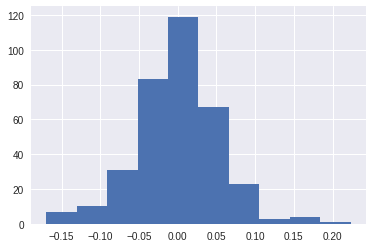

In [13]:
df['act_residual'] = df['cbrt_PCpc'] - df['raw_prediction']
plt.hist(df['act_residual']);

A Q-Q plot can help us visualize the normality.

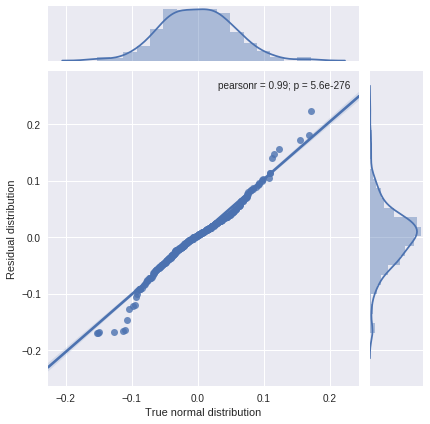

In [14]:
norm_dist = np.random.normal(df['act_residual'].mean(), df['act_residual'].std(), size=len(df))
g = sns.jointplot(x=pd.Series(norm_dist).sort_values(), y=df['act_residual'].sort_values(), kind='reg');
g.set_axis_labels('True normal distribution', 'Residual distribution');

<H3>scedasticity</H3><br>
The scedasticity of the raw predictions is not perfectly homogeneous; it's not bad, either.

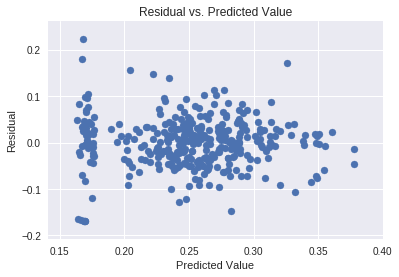

In [15]:
plt.scatter(y=df['act_residual'], x=df['raw_prediction']);
plt.xlabel('Predicted Value');
plt.ylabel('Residual');
plt.title('Residual vs. Predicted Value');

So we can see that, while there is still a lot of noise present, and we have a pretty low R-squared score, everything seems to be behaving fairly well.<br><br>
<H3>Predictive Power</H3><br>
Now let's look at the actual predictions and how they stack up. Up until now, we were actually looking at the predicted cube root of the property crime per capita, but the model is intended to predict nominal property crime in every city. We'll tranform our predictions back to those values and see how the compare to the known results.

In [16]:
pred = df['pred_PC']
targ = df['Property crime']
df['residual'] = pred - targ

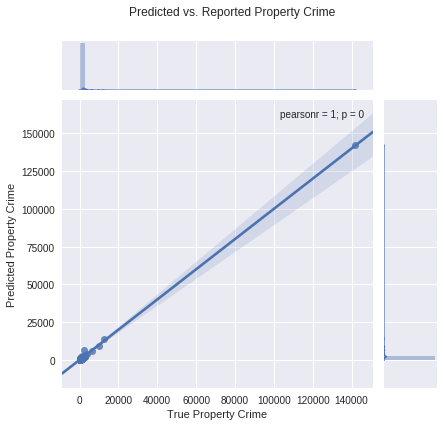

In [17]:
g = sns.jointplot(x='Property crime', y='pred_PC', data=df, kind='reg');
g.set_axis_labels('True Property Crime', 'Predicted Property Crime');
plt.subplots_adjust(top=.9);
g.fig.suptitle('Predicted vs. Reported Property Crime');

When comparing the predicted property crime rate to predicted, Seaborn gives us a perfect pearsonr score and a p value of zero. That's a good sign :)<br><br>
Let's take a look at the distribution of residuals after transforming the raw predictions to our target variable.


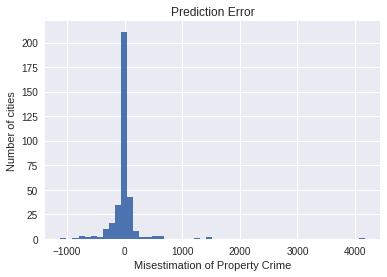

In [18]:
plt.hist(df['residual'], bins=50);
plt.title('Prediction Error');
plt.xlabel('Misestimation of Property Crime');
plt.ylabel('Number of cities');

We see quite a bit of skewness. This comes from the fact that our model isn't perfect in the transformed model space, and the odd behavior at the tails is exacerbated by the reverse transformation process. However, the vast majority of predictions are very close to the target.<br><br>
Finally, let's look at the R-squared score of our predictions against the target variable after transforming out of the prediction space:

In [21]:
print(metrics.r2_score(df['Property crime'], df['pred_PC']), '\nNice!')

0.998318935878 
Nice!


<H2>Conclusion</H2><br><br>
My model isn't perfect, but after playing with this data some time I understand how difficult the problem is. For my first linear regression model, I'm happy with the outcome.